# Corn (Maize) Production – FAOSTAT Data

### Objective
The objective of this study is to forecast corn (maize) production for the next five years using
time series forecasting models and to compare their performance using quantitative error metrics.

### Models Used
- ARIMA
- SARIMA
- Auto-ARIMA
- Random Forest (Benchmark)

### Evaluation Metrics
- Mean Absolute Error (MAE)
- Mean Squared Error (MSE)
- Root Mean Squared Error (RMSE)


## Importing Required Libraries


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

import pmdarima as pm

import warnings
warnings.filterwarnings("ignore")


## Load Dataset
The dataset is sourced from FAOSTAT and contains annual corn (maize) production values.


In [3]:
df = pd.read_csv("FAOSTAT_corn_maize.csv")
df.head()


,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Unit,Value,Flag,Flag Description,Note
0,QCL,Crops and livestock products,32,Argentina,5510,Production,112,Maize (corn),1961,1961,t,4850000,A,Official figure,NaN
1,QCL,Crops and livestock products,32,Argentina,5510,Production,112,Maize (corn),1962,1962,t,5220000,A,Official figure,NaN
2,QCL,Crops and livestock products,32,Argentina,5510,Production,112,Maize (corn),1963,1963,t,4360000,A,Official figure,NaN
3,QCL,Crops and livestock products,32,Argentina,5510,Production,112,Maize (corn),1964,1964,t,5350000,A,Official figure,NaN
4,QCL,Crops and livestock products,32,Argentina,5510,Production,112,Maize (corn),1965,1965,t,5140000,A,Official figure,NaN


In [4]:
print(df.columns)

df = df[['Year', 'Value']].dropna()

df.columns = ['Year', 'Production']

df['Year'] = pd.to_datetime(df['Year'], format='%Y')
df.set_index('Year', inplace=True)

df.head()


Index(['Domain Code', 'Domain', 'Area Code (M49)', 'Area', 'Element Code',
       'Element', 'Item Code (CPC)', 'Item', 'Year Code', 'Year', 'Unit',
       'Value', 'Flag', 'Flag Description', 'Note'],
      dtype='object')


,Production
Year,
1961-01-01,4850000
1962-01-01,5220000
1963-01-01,4360000
1964-01-01,5350000
1965-01-01,5140000


## 4. Original Time Series Plot


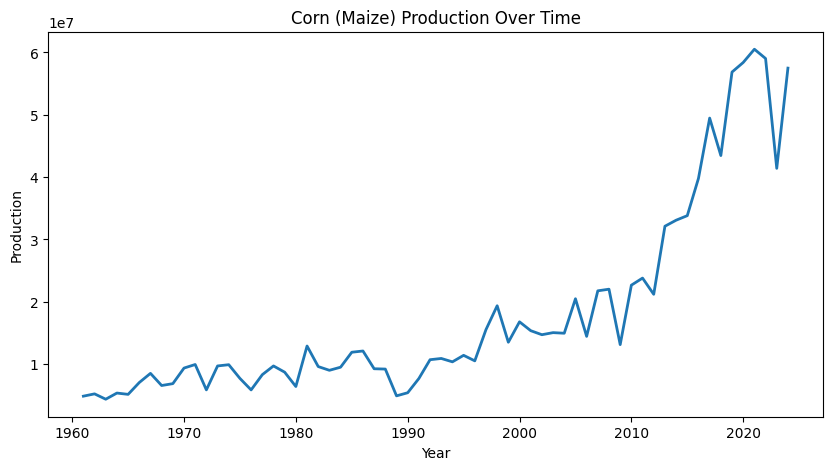

In [5]:
plt.figure(figsize=(10,5))
plt.plot(df['Production'], linewidth=2)
plt.title("Corn (Maize) Production Over Time")
plt.xlabel("Year")
plt.ylabel("Production")
plt.show()


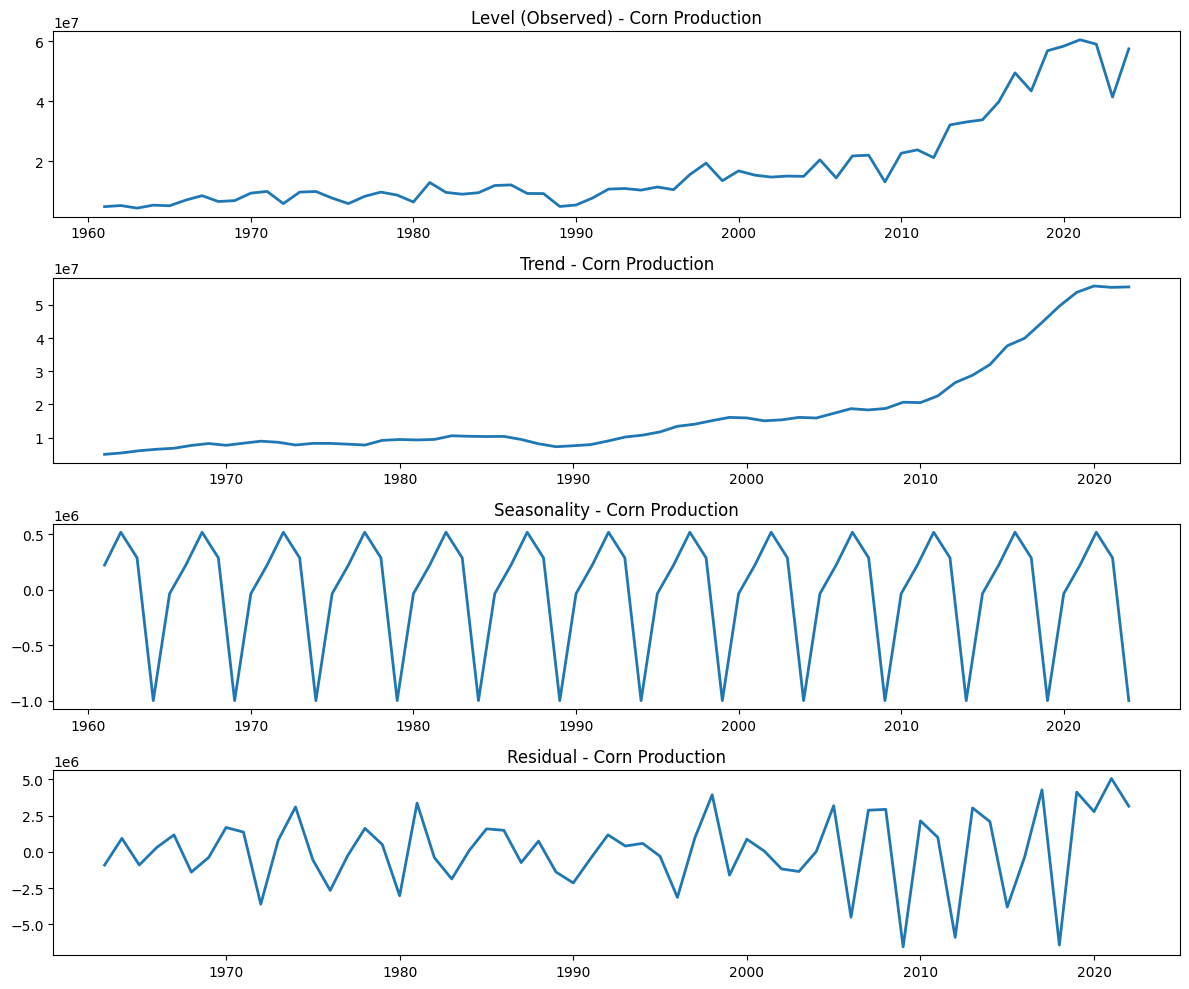

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Select the series
series = df['Production'].dropna()

# Time series decomposition
decomposition = seasonal_decompose(series, model='additive', period=5)

# Plot components
plt.figure(figsize=(12,10))

plt.subplot(4,1,1)
plt.plot(decomposition.observed, linewidth=2)
plt.title("Level (Observed) - Corn Production")

plt.subplot(4,1,2)
plt.plot(decomposition.trend, linewidth=2)
plt.title("Trend - Corn Production")

plt.subplot(4,1,3)
plt.plot(decomposition.seasonal, linewidth=2)
plt.title("Seasonality - Corn Production")

plt.subplot(4,1,4)
plt.plot(decomposition.resid, linewidth=2)
plt.title("Residual - Corn Production")

plt.tight_layout()
plt.show()


## 5. Stationarity Test (ADF)


In [28]:
def adf_test(series):
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]}")
    print(f"P-value: {result[1]}")

adf_test(df['Production'])


ADF Statistic: 0.23205764477161409
P-value: 0.9740033683358598


## 6. Log Transformation and Differencing


In [29]:
df['Log_Prod'] = np.log(df['Production'])
df['Diff_Log_Prod'] = df['Log_Prod'].diff()

df.dropna(inplace=True)

adf_test(df['Diff_Log_Prod'])


ADF Statistic: -9.094475458137262
P-value: 3.7471591306358054e-15


## 7. Train-Test Split


In [30]:
train = df.iloc[:-5]
test = df.iloc[-5:]


## 8. ARIMA Model


In [31]:
arima_model = ARIMA(train['Log_Prod'], order=(1,1,1))
arima_fit = arima_model.fit()

arima_forecast = arima_fit.forecast(steps=5)
arima_forecast = np.exp(arima_forecast)


## 9. SARIMA Model


In [32]:
sarima_model = SARIMAX(
    train['Log_Prod'],
    order=(1,1,1),
    seasonal_order=(1,1,1,12)
)

sarima_fit = sarima_model.fit()
sarima_forecast = np.exp(sarima_fit.forecast(steps=5))



## 10. AUTO ARIMA Model


In [34]:
auto_model = pm.auto_arima(
    train['Log_Prod'],
    seasonal=False,
    stepwise=True,
    suppress_warnings=True
)

auto_forecast = np.exp(auto_model.predict(n_periods=5))


## 11. Random Forest Regressor


In [35]:
df['Time'] = np.arange(len(df))

X = df[['Time']]
y = df['Production']

X_train, X_test = X.iloc[:-5], X.iloc[-5:]
y_train, y_test = y.iloc[:-5], y.iloc[-5:]

rf = RandomForestRegressor(n_estimators=300, random_state=42)
rf.fit(X_train, y_train)

rf_forecast = rf.predict(X_test)


## 12. Model Comparison (RMSE, MSE, MAE)


In [36]:
def metrics(actual, predicted):
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mse = mean_squared_error(actual, predicted)
    mae = mean_absolute_error(actual, predicted)
    return rmse, mse, mae

results = []

results.append(["ARIMA", *metrics(test['Production'], arima_forecast)])
results.append(["SARIMA", *metrics(test['Production'], sarima_forecast)])
results.append(["AUTO ARIMA", *metrics(test['Production'], auto_forecast)])
results.append(["Random Forest", *metrics(test['Production'], rf_forecast)])

rmse_df = pd.DataFrame(
    results, 
    columns=["Model", "RMSE", "MSE", "MAE"]
)

rmse_df


,Model,RMSE,MSE,MAE
0,ARIMA,8.447698e+06,7.136361e+13,8.375636e+06
1,SARIMA,8.675356e+06,7.526181e+13,8.101145e+06
2,AUTO ARIMA,9.157606e+06,8.386175e+13,7.177541e+06
3,Random Forest,7.622260e+06,5.809884e+13,7.322086e+06


## 13. RMSE Comparison Bar Plot


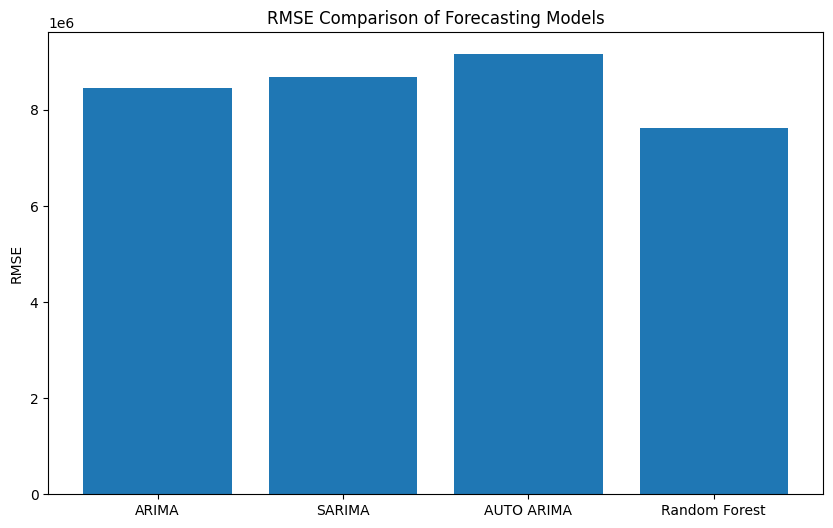

In [37]:
plt.figure(figsize=(10,6))
plt.bar(rmse_df['Model'], rmse_df['RMSE'])
plt.title("RMSE Comparison of Forecasting Models")
plt.ylabel("RMSE")
plt.show()


## 14. Final 5-Year Forecast using Best Model (AUTO ARIMA)


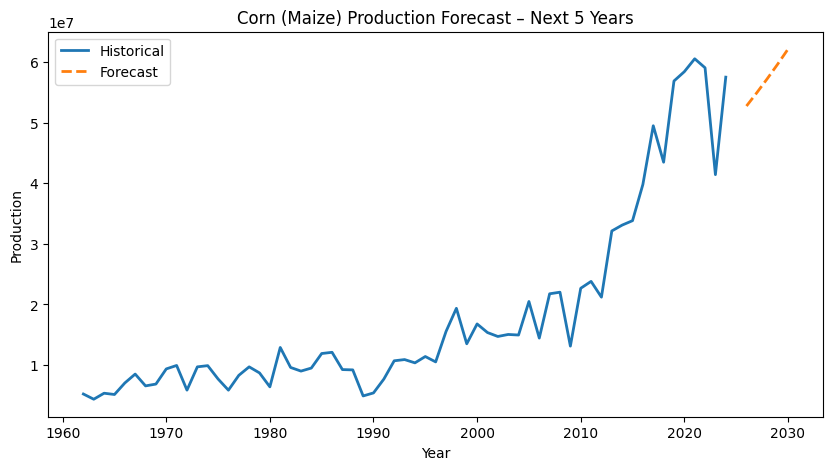

In [38]:
forecast_years = pd.date_range(
    start=df.index[-1] + pd.DateOffset(years=1),
    periods=5,
    freq='Y'
)

plt.figure(figsize=(10,5))
plt.plot(df['Production'], label="Historical", linewidth=2)
plt.plot(forecast_years, auto_forecast, linestyle='--', label="Forecast", linewidth=2)

plt.title("Corn (Maize) Production Forecast – Next 5 Years")
plt.xlabel("Year")
plt.ylabel("Production")
plt.legend()
plt.show()
